In [2]:
import matplotlib.pyplot as plt
import numpy as np
from pypokerengine.players import BasePokerPlayer
from pypokerengine.api.game import setup_config, start_poker
from pypokerengine.utils.card_utils import gen_cards, estimate_hole_card_win_rate
import inspect
from pypokerengine.engine.hand_evaluator import HandEvaluator
from pypokerengine.engine.card import Card


In [3]:
NB_SIMULATION = 100
class HonestPlayer(BasePokerPlayer):
    def __init__(self, raise_wr = 0.6, call_wr = 0.3):
        super().__init__() 
        self.raise_wr = raise_wr
        self.call_wr = call_wr
        
    def declare_action(self, valid_actions, hole_card, round_state):
        curframe = inspect.currentframe()
        calframe = inspect.getouterframes(curframe, 2)
        community_card = round_state['community_card']
        win_rate = estimate_hole_card_win_rate(
                nb_simulation=NB_SIMULATION,
                nb_player=self.nb_player,
                hole_card=gen_cards(hole_card),
                community_card=gen_cards(community_card)
                )
        if win_rate >= self.raise_wr:
            #print('Raising)', win_rate)
            action = valid_actions[2]  # fetch bet action info
            valid_amounts = action['amount']
            raise_amount =  (valid_amounts['max'] - valid_amounts['min'])/ 5.0 + valid_amounts['min']
            return valid_actions[2]['action'], raise_amount
        elif win_rate >= self.call_wr:
            #print('Calling')
            action = valid_actions[1]  # fetch CALL action info
        else:
            call_amount = valid_actions[1]['amount']
            if(call_amount == 0):
                #print('Calling')
                return valid_actions[1]['action'], valid_actions[1]['amount']
            #print('Folding')
            action = valid_actions[0]  # fetch FOLD action info
        return action['action'], action['amount']

    def receive_game_start_message(self, game_info):
        self.nb_player = game_info['player_num']

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        pass

In [19]:
def iterate_actions(hand_data):
    """Iterates over all actions in the 'action_histories' of a given hand.
    
    Args:
    hand_data: A dictionary representing a hand of poker.
    
    Yields:
    A tuple containing the action type, the amount, the player's UUID, and the round.
    """
    if(hand_data):
        for round_name, actions in hand_data['action_histories'].items():
            for action in actions:
                yield (action['action'], action.get('amount'), action['uuid'], round_name)

class BijPlayer(BasePokerPlayer):
    def __init__(self):
        super().__init__() 
        self.player_histories = {}
        self.player_tendencies = {}
        self.hand_evaluator = HandEvaluator()
        self.INVERTED_HAND_STRENGTH_MAP = {value: key for key, value in self.hand_evaluator.HAND_STRENGTH_MAP.items()}

        self.player_showdown_score_histories = {}
        self.player_showdown_score_metrics = {}

        self.player_states = []

    def make_score(self, ri):
        hand_strength = self.INVERTED_HAND_STRENGTH_MAP[ri['hand']['strength']]
        hand_high = ri['hand']['high']
        hand_low = ri['hand']['low']
        hole_high = ri['hole']['high']
        hole_low = ri['hole']['low']
        return (hand_strength << 8) | (hand_high << 12) | (hand_low << 8) | (hole_high << 4) | hole_low

    # def dfs_simulation(self, next_player, seats):
    #     # Get the valid actions for the player

    #     # Get the value of each action

    #     # Get the probability of each action

    #     # Calculate the EV from each action as a weighted sum 
    #     ev_sum = prob_fold * value_fold + prob_call * value_call + prob_raise * value_raise
        
    def declare_action(self, valid_actions, hole_card, round_state):
        next_player = round_state['next_player']

        player_costs = {}
        # Sum the total cost so far for each player
        #for action in round_state['action_histories']:
        #    player_costs[action['uuid']] += action['amount']

        participating_players = [player for player in round_state['seats'] if(player['state'] == 'participating')]
                
            
            
        
        # Determine the round state.
        # print('-------------------start--------------')
        # print('round_state: ', round_state.keys())
        # print('round_state: ', round_state['action_histories'])
        # print('round_state: ', round_state['seats'])
        # print('-------------------end--------------')
        # Calculate the EV of each action: 

        # Expected value of the fold action.
        ev_fold = 0
        # Expected value of the call action.
        #ev_call = calc_ev('call')
        # test
        return valid_actions[1]['action'], valid_actions[1]['amount']

    def receive_game_start_message(self, game_info):
        self.nb_player = game_info['player_num']

    def receive_round_start_message(self, round_count, hole_card, seats):
        pass

    def receive_street_start_message(self, street, round_state):
        pass

    def receive_game_update_message(self, action, round_state):
        self.player_states += [round_state['seats'][round_state['next_player']]['state']]
        #pass

    def receive_round_result_message(self, winners, hand_info, round_state):
        print('Round state seats at end: ', round_state)
        showdown_players = [player for player in round_state['seats'] if(player['state'] == 'participating')]
        # Get pot size
        round_state['pot']

        # Get cost for each player
        player_costs = {}
        for street, player_actions in round_state['action_histories'].items():
            print('on streat: ', street)
            for action in street:
                uuid = street[action]['uuid']
                player_costs[uuid] += action['amount']

        for action_type, amount, player_uuid, round_name in iterate_actions(round_state):
            try:
                self.player_histories[player_uuid] += [action_type]
            except KeyError:
                self.player_histories[player_uuid] = [action_type]
        
        # Calculate fold percentage of player
        for player in self.player_histories:
            count_fold = self.player_histories[player].count('FOLD')
            count_call = self.player_histories[player].count('CALL')
            count_raise = self.player_histories[player].count('RAISE')
            count_opportunities = count_fold+count_call+count_raise
            #print(player, count_fold, count_call, count_raise, count_call / count_opportunities)
            
            self.player_tendencies[player] = {'rate_fold': count_fold / count_opportunities,
                                              'rate_call': count_call / count_opportunities,
                                              'rate_raise': count_raise / count_opportunities,
                                              'count_opportunities': count_opportunities}
        
        # Now we calculate the average showdown strength of each player
        for player in hand_info:
            player_uuid = player['uuid']
            ri = player['hand']
            score = self.make_score(ri)
            
            try:
                self.player_showdown_score_histories[player_uuid] += [score]
            except KeyError:
                self.player_showdown_score_histories[player_uuid] = [score]
            self.player_showdown_score_metrics[player_uuid] = {'mean': np.mean(self.player_showdown_score_histories[player_uuid]),
                                                               'support': len(self.player_showdown_score_histories[player_uuid])}

        # for player in self.player_tendencies:
        #     print(player)
        #     print(self.player_tendencies.get(player))
        #     print(self.player_showdown_score_metrics.get(player))
            

In [20]:
from collections import Counter

results_dict = {'p1': [], 'p2': [], 'p3': [], 'p4': []}
initial_stack = 1000
for i in range(1):
    config = setup_config(max_round=1000, initial_stack=initial_stack, small_blind_amount=5)
    config.register_player(name="p1", algorithm=HonestPlayer())
    config.register_player(name="p2", algorithm=HonestPlayer(raise_wr = 0.9, call_wr=0.7))
    config.register_player(name="p3", algorithm=HonestPlayer(raise_wr = 0.3, call_wr=0.1))
    bijPlayer = BijPlayer()
    config.register_player(name="p4", algorithm=bijPlayer)
    game_result = start_poker(config, verbose=0)
    #print(i, game_result)
    players = game_result['players']
    for player in players:
        results_dict[player['name']] += [player['stack'] - initial_stack]
        
        

print(results_dict)
print(Counter(bijPlayer.player_states))


Round state seats at end:  {'street': 'showdown', 'pot': {'main': {'amount': 1025.16}, 'side': []}, 'community_card': ['H8', 'C7', 'CQ', 'D3', 'DQ'], 'dealer_btn': 0, 'next_player': 2, 'small_blind_pos': 1, 'big_blind_pos': 2, 'round_count': 1, 'small_blind_amount': 5, 'seats': [{'name': 'p1', 'uuid': 'mcqyerbtyhxnnuxiyngziz', 'stack': 1000, 'state': 'folded'}, {'name': 'p2', 'uuid': 'blqpmjiqvsejuolzdajovu', 'stack': 995, 'state': 'folded'}, {'name': 'p3', 'uuid': 'etqphrordzaxubqnglfbxh', 'stack': 1514.92, 'state': 'participating'}, {'name': 'p4', 'uuid': 'xnrfapynzognbylguecjiu', 'stack': 489.91999999999996, 'state': 'participating'}], 'action_histories': {'preflop': [{'action': 'SMALLBLIND', 'amount': 5, 'add_amount': 5, 'uuid': 'blqpmjiqvsejuolzdajovu'}, {'action': 'BIGBLIND', 'amount': 10, 'add_amount': 5, 'uuid': 'etqphrordzaxubqnglfbxh'}, {'action': 'CALL', 'amount': 10, 'paid': 10, 'uuid': 'xnrfapynzognbylguecjiu'}, {'action': 'FOLD', 'uuid': 'mcqyerbtyhxnnuxiyngziz'}, {'actio

TypeError: string indices must be integers, not 'str'

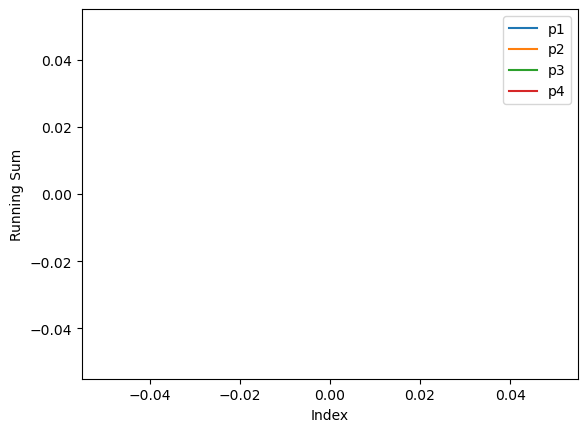

In [17]:

def plot_running_sums(data):
  """Plots the running sums of a dictionary of arrays.

  Args:
    data: A dictionary where the keys are labels and the values are arrays of numbers.
  """

  for label, values in data.items():
    running_sum = np.cumsum(values)
    plt.plot(running_sum, label=label)

  plt.xlabel("Index")
  plt.ylabel("Running Sum")
  plt.legend()
  plt.show()

plot_running_sums(results_dict)